In [1]:
#Import modules
import pandas as pd
import matplotlib
from matplotlib import pyplot as plot
from datetime import datetime, date, timedelta
from matplotlib.pyplot import figure  
import numpy as np
import math

- FEATURES
    * Time at stop
    * Day of the week
    * Forsinkelse
    * Hour of departure
    * Passengers on/off (passasjerer ombord)
    * Område
    
- FEATURE ENGINEERING
    * Forsinkelse per day of the week
    * Average passengers per område
    * Average time at the stop per område
    * Time at the stop per day of the week
    * Busses per hour (departure)
    * Passenger per time

In [2]:
url = 'https://raw.githubusercontent.com/umaimehm/Intro_to_AI/master/assignment1/Ruter_data.csv'

In [3]:
df = pd.read_csv(url, sep=';')

In [4]:
#Converts str to time, replace hours over 24 with hours under 24 changeDate is set to True, 
#the date change with the change of time (use it for first run only)
def strToTime(rowName, changeDate=False):
    x=rowName                               #Name of the row evaluated
    for i, row in df.iterrows():            #df.iterrows() is the buildt in iter from pandas, haven't read documentation, too tierd right now
        hourStr = row[x][:2]
        try:                                #Convert string to int. If value error (ie not a number)
            hourInt = int(hourStr)
        except ValueError:
            df.drop(i, inplace=True)        #Remove the item from the list
        except:
            print("error")                  #For debugging only
            
        if hourInt>23:                                   ##Checks if %H is < 23            
            try:              
                hourInt = hourInt - 24                      #And subtracts 24h
                hourStr = str("%02d" % hourInt) + ":"       #Formats to 2-digit format
                df.at[i,x] = hourStr+row[x][3:]             #Inserts back into string
                
                if changeDate:
                    df.at[i,"Dato"]=row["Dato"] +  timedelta(days=1) #Adds one day to date where time has changed above             

            except:                                #Error msg if it fails!
                print("Error on converting:")
                print(df.iloc[i])

    
    df[x] = pd.to_datetime(df[x],format= '%H:%M:%S' ).dt.time  #Change from string to date time object
    print("done with " + x)                                       #The loop take some time, so just provideing som feedback


In [5]:
df['Dato'] = pd.to_datetime(df['Dato'])                #Convert date to a datetime object
strToTime('Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra', changeDate = True)  #Convert time to a datetime object, change date when time is over 24:00:00
strToTime('Tidspunkt_Faktisk_Avgang_Holdeplass_Fra')         #Change time to datetime, no need for future date change
strToTime('Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra')
strToTime('Tidspunkt_Planlagt_Avgang_Holdeplass_Fra')

done with Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra
done with Tidspunkt_Faktisk_Avgang_Holdeplass_Fra
done with Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra
done with Tidspunkt_Planlagt_Avgang_Holdeplass_Fra


In [6]:
#Rename cells to shorter / more precise names
df = df.rename(columns={"Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra":"Faktisk_Ankomst", "Tidspunkt_Faktisk_Avgang_Holdeplass_Fra":"Faktisk_Avgang", "Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra":"Planlagt_Ankomst", "Tidspunkt_Planlagt_Avgang_Holdeplass_Fra":"Planlagt_Avgang", "Passasjerer_Ombord":"Passasjerer_Flux"})

## Feature 1: time spent at the stop

In [7]:
#Subtract Faktisk Avgang with Faktisk Ankomst to find time spent at the stop. (Datetime(1,1,1,0,0,0) is a dummy placeholder to be able to subtract.)
df['Time_At_Stop'] = df.apply(lambda row: datetime.combine(datetime(1,1,1,0,0,0), row.Faktisk_Avgang) - datetime.combine(datetime(1,1,1,0,0,0), row.Faktisk_Ankomst), axis = 1)

## Feature 2: Weekday

In [8]:
df['Ukedag'] = df['Dato'].dt.day_name()

## Feature 3: Arrival delay

In [9]:
# Subtract Faktisk Avgang with Planlagt Avgang to find the delay/anticipation in departure. (Datetime(1,1,1,0,0,0) is a dummy placeholder to be able to subtract.)
df['Forsinkelse'] = df.apply(lambda row: datetime.combine(datetime(1,1,1,0,0,0), row.Faktisk_Ankomst) - datetime.combine(datetime(1,1,1,0,0,0), row.Planlagt_Ankomst), axis = 1)

## Feature 4: Hour of departure

In [10]:
df['Avgang_Time'] = df.apply(lambda row: row["Faktisk_Avgang"].hour, axis = 1)

## Features 5 and 6: Are already in the data set as
- Passasjerer_Flux
- Område


## Feature Engineering 1: Forsinkelse per day of the week

In [11]:
#Cleaning the data
lower_limit, upper_limit = df.Forsinkelse.quantile([0.025,0.975])
lower_limit, upper_limit

(Timedelta('-1 days +23:53:01.700000'), Timedelta('0 days 00:09:14.600000'))

In [12]:
df.shape

(5949, 21)

In [13]:
df2 = df[(df.Forsinkelse>lower_limit)&(df.Forsinkelse<upper_limit)]
df2.shape

(5651, 21)

Text(0.5, 1.0, 'Forsinkelse')

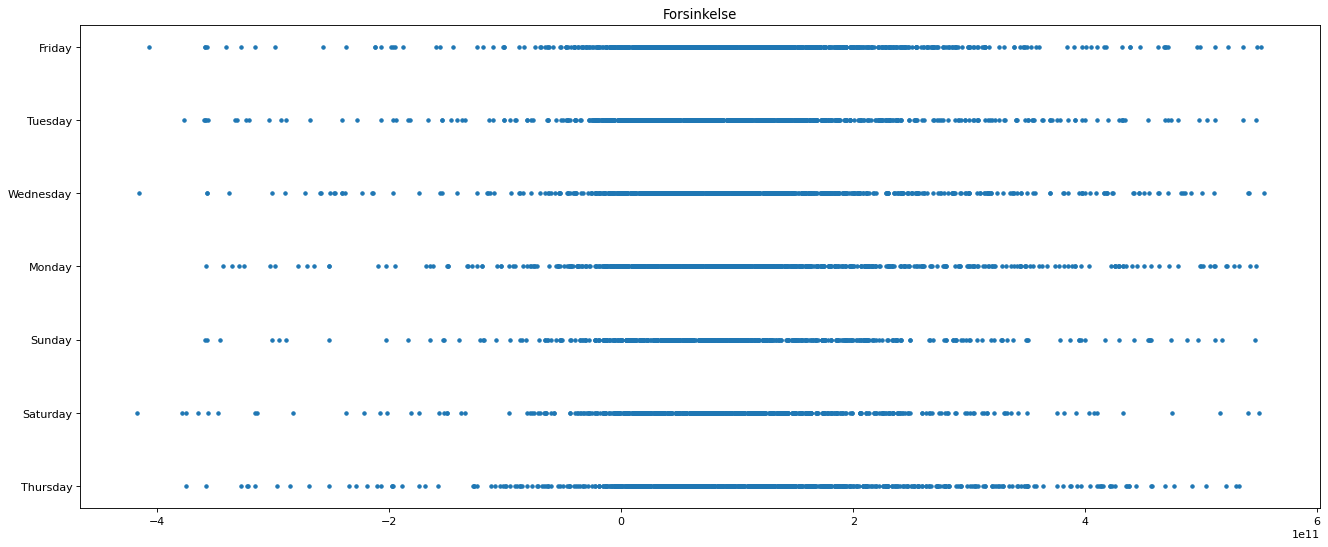

In [14]:
figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')  #Set the size of plotdf = df.sort_values('Dato', ascending=True)
plot.plot(df2['Forsinkelse'], df2['Ukedag'], '.')                      #Plotting Stoptime with date, '.' - gives scatter plot
plot.xticks(rotation='horizontal')
plot.title('Forsinkelse')

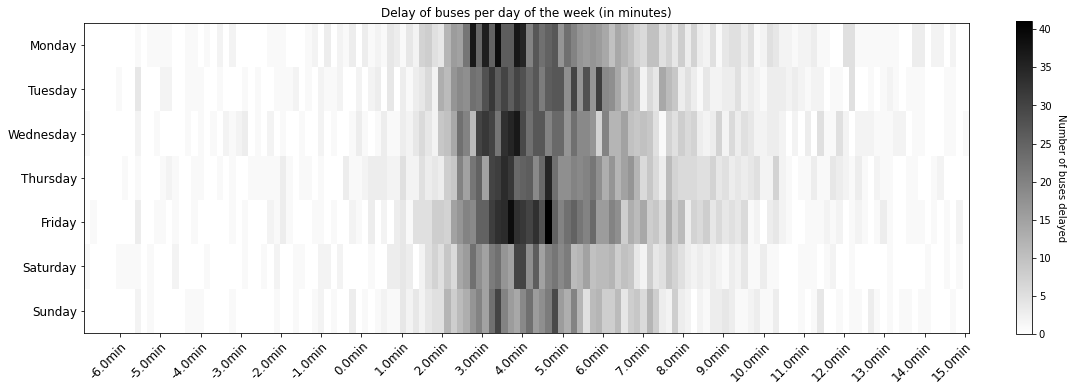

In [15]:
#This section is heavily based on matplotlib's documentation
    #https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html
    #https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.tick_params.html#matplotlib.pyplot.tick_params
    #https://matplotlib.org/3.1.1/api/colorbar_api.html#matplotlib.colorbar.Colorbar
def countDelays(rowNameY, rowNameX):
    
    minDelay = df2[rowNameX].min().total_seconds()
    maxDelay = df2[rowNameX].max().total_seconds() - minDelay
    bins = 140
    grid = np.zeros((7, bins))
    
    #Calculate minimum and maximum minute values (min/max ticks)
    i=0
    minMin, detractSec = divmod(minDelay, 60)
    if minMin<0:
        minMin = minMin+1
        detractSec = 60-detractSec
    
    maxMin, maxRest = divmod(maxDelay, 60)
    if maxMin<0:
        maxMin = maxMin+1
        maxRest = 60-maxRest
    
    #Calculate number of ticks and add corresponding label
    nrTicks = int(maxMin - minMin)
    ticks = [None] * nrTicks
    
    while i<nrTicks:
        ticks[i] = str(minMin + i)+"min"
        i = i+1
        
    days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    
    #Populate grid array
    for j, row in df2.iterrows():
        day = row[rowNameY]
        delay = row[rowNameX].total_seconds() - minDelay
        toBin = math.floor(delay/maxDelay*(bins-1))
        
        dayNr=-1
        
        k=0
        while k<7:
            if day==days[k]:
                dayNr=k
            k=k+1
        
        if(dayNr != -1):
            grid[dayNr, toBin] = grid[dayNr, toBin] + 1
    
    #Define heatmap
    fig, ax = plot.subplots(figsize=(15, 15))
    im = ax.imshow(grid, cmap='gist_yarg')
    ax.set_aspect(7)

    #Setting up ticks
    ax.set_xticks(np.arange(len(ticks)))
    plot.xticks(np.arange(((detractSec/10)-(detractSec/100)), (140-((maxRest/10)-(maxRest/100))), step=(140/len(ticks))))
    ax.set_xticklabels(ticks)
    ax.set_yticks(np.arange(len(days)))
    ax.set_yticklabels(days)
    ax.tick_params(axis='both', labelsize=12)
    plot.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    
    #Colourbar
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.0165)
    cbar.ax.set_ylabel("Number of buses delayed", rotation=-90, va="bottom")
    
    #Set title and show
    ax.set_title("Delay of buses per day of the week (in minutes)")
    fig.tight_layout()
    plot.show()

#Call function
countDelays('Ukedag', 'Forsinkelse')

In [16]:
df = df.sort_values('Dato', ascending=True)

## Feature Engineering 2: Average passengers per område

Text(0, 0.5, 'Count')

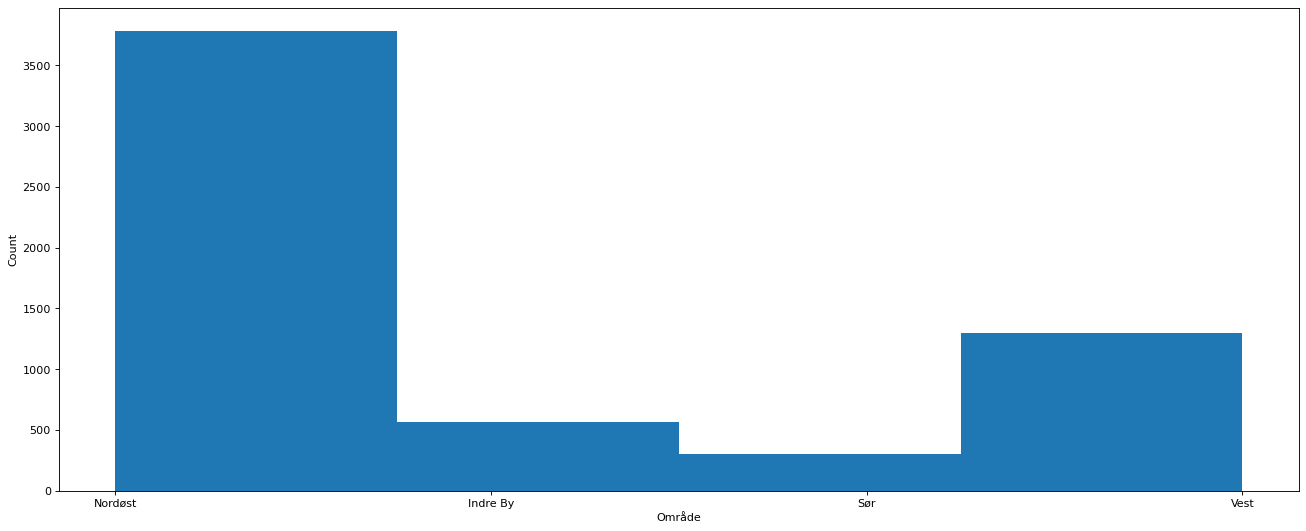

In [17]:
figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')  #Set the size of plot
plot.hist(df.Område, bins=4, rwidth=1)
plot.xlabel('Område')
plot.ylabel('Count')

## Feature Engineering 3: Average time at the stop per område

In [18]:
x = "Time_At_Stop"                                                                 #The col that will be converted
df3 = df2.sort_values('Dato', ascending=True)
df3['Time_At_Stop_Float'] = df3.apply(lambda row: row[x].total_seconds(), axis = 1)  #Converting datetime to float
timePrStopArea=df3[['Område', 'Time_At_Stop_Float']].groupby(['Område']).mean()     #Grouping by area and taking the mean of stop time
timePrStopWeekday=df3[['Ukedag', 'Time_At_Stop_Float']].groupby(['Ukedag']).mean()     #Grouping by area and taking the mean of stop time


df2.head()

,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjetype,Linjefylke,Linjenavn,...,Faktisk_Ankomst,Faktisk_Avgang,Planlagt_Ankomst,Planlagt_Avgang,Kjøretøy_Kapasitet,Passasjerer_Flux,Time_At_Stop,Ukedag,Forsinkelse,Avgang_Time
0,15006-2020-08-10T10:24:00+02:00,2020-10-08,Viken,Vest,Bærum,Nordliveien,Tjernsmyr,Lokal,Viken,150,...,10:53:53,10:53:59,10:53:00,10:53:00,112,5,00:00:06,Thursday,00:00:53,10
1,15002-2020-08-15T12:54:00+02:00,2020-08-15,Viken,Vest,Bærum,Nadderud stadion,Bekkestua bussterminal (Plattform C),Lokal,Viken,150,...,13:12:20,13:12:26,13:12:00,13:12:00,112,5,00:00:06,Saturday,00:00:20,13
2,15004-2020-08-03T09:54:00+02:00,2020-03-08,Viken,Vest,Bærum,Ringstabekkveien,Skallum,Lokal,Viken,150,...,10:18:56,10:19:21,10:19:00,10:19:00,112,6,00:00:25,Sunday,-1 days +23:59:56,10
3,15003-2020-07-27T13:00:00+02:00,2020-07-27,Viken,Vest,Bærum,Gruvemyra,Gullhaug,Lokal,Viken,150,...,13:52:04,13:52:26,13:51:00,13:51:00,112,10,00:00:22,Monday,00:01:04,13
4,15002-2020-08-27T07:15:00+02:00,2020-08-27,Viken,Vest,Bærum,Lysaker stasjon (Plattform A),Tjernsmyr,Lokal,Viken,150,...,07:34:13,07:34:53,07:33:00,07:33:00,112,10,00:00:40,Thursday,00:01:13,7


In [19]:
lower_limit, upper_limit = df3.Time_At_Stop_Float.quantile([0.000,0.985])
lower_limit, upper_limit
df3 = df3[(df3.Time_At_Stop_Float>lower_limit)&(df3.Time_At_Stop_Float<upper_limit)]

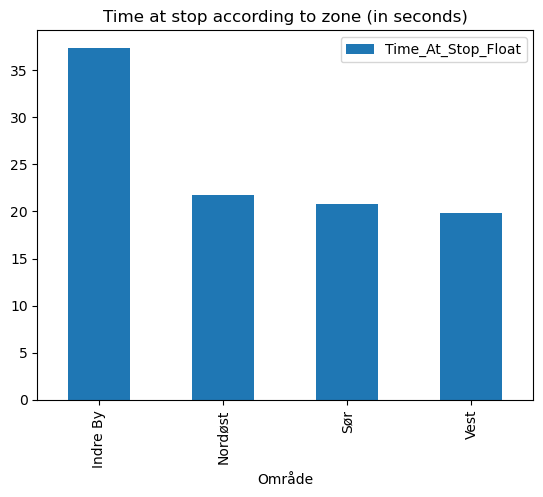

In [20]:
with plot.style.context('default'):  #Using the default plot theme

    timePrStopArea.plot.bar()                     #Barplot of the dataframe
    plot.rcParams["figure.figsize"] = [10, 8]     #Setting size
    plot.xticks(rotation='vertical')
    plot.title('Time at stop according to zone (in seconds)')            

## Feature Engineering 4: Time at the stop per day of the week

In [21]:
L = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
timePrStopWeekday = timePrStopWeekday.reindex(L)  #reindex to get monday first
timePrStopWeekday.head()

,Time_At_Stop_Float
Ukedag,
Monday,23.041808
Tuesday,23.397494
Wednesday,24.219370
Thursday,24.030481
Friday,20.038988


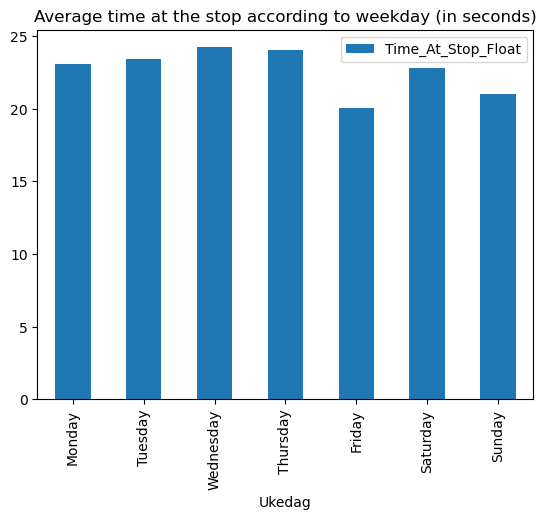

In [22]:
with plot.style.context('default'):

    timePrStopWeekday.plot.bar()
    plot.rcParams["figure.figsize"] = [10, 8]
    plot.xticks(rotation='vertical')
    plot.title('Average time at the stop according to weekday (in seconds)')

In [23]:
df3["Time_At_Stop_Float"].max()

190.0

Text(0.5, 1.0, 'Stop Time Based on day of the week')

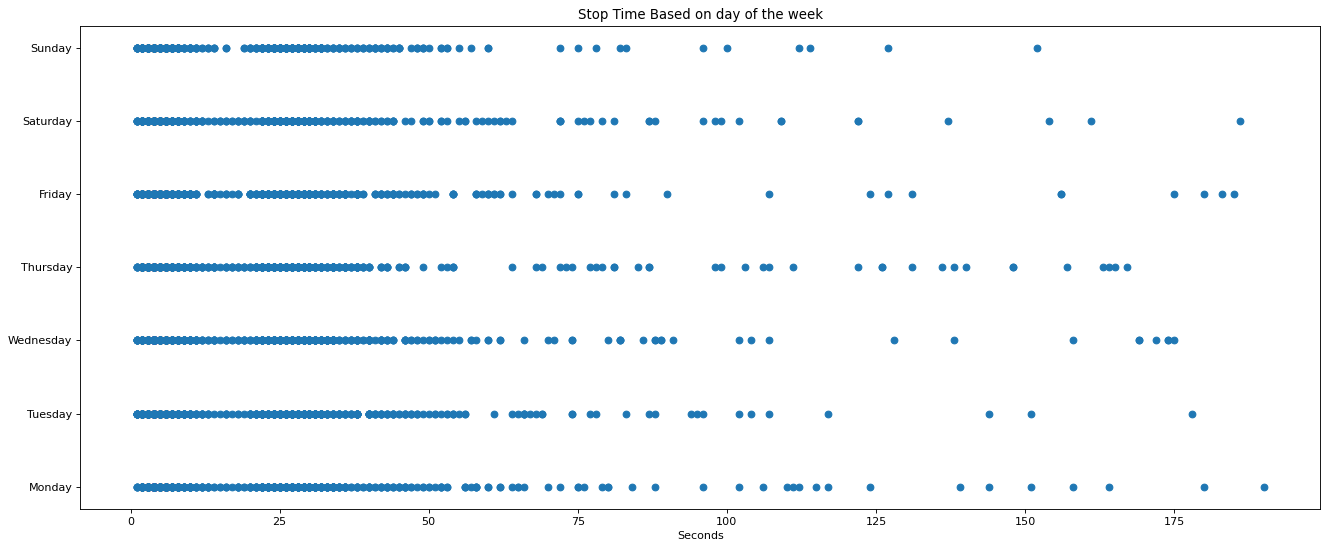

In [33]:
figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')  #Set the size of plotdf = df.sort_values('Dato', ascending=True)                             #Sorting dates (dont know if this is needed)
plot.plot(df3['Time_At_Stop_Float'], df3['Ukedag'], 'o')                      #Plotting Stoptime with date, 'o' - gives scatter plot
plot.xticks(rotation='horizontal')
plot.xlabel("Seconds")
plot.title('Stop Time Based on day of the week')

In [37]:
print(df3['Time_At_Stop'].max())
print(df3["Time_At_Stop"].mean())


0 days 00:03:10
0 days 00:00:18.102827


,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjetype,Linjefylke,Linjenavn,...,Faktisk_Avgang,Planlagt_Ankomst,Planlagt_Avgang,Kjøretøy_Kapasitet,Passasjerer_Flux,Time_At_Stop,Ukedag,Forsinkelse,Avgang_Time,Time_At_Stop_Float
2509,10011-2020-06-01T10:45:00+02:00,2020-01-06,Oslo,Nordøst,Alna,Kjelsrud (mot Furuset),IKEA Furuset (mot Furuset),Lokal,Viken,100,...,11:03:45,11:03:00,11:03:00,151,2,00:00:06,Monday,00:00:39,11,6.0
3933,40004-2020-06-01T11:55:00+02:00,2020-01-06,Viken,Nordøst,Gjerdrum,Vestby,Skei,Lokal,Viken,410,...,12:36:44,12:34:00,12:34:00,106,-9,00:00:08,Monday,00:02:36,12,8.0
984,12011-2020-06-01T14:15:00+02:00,2020-01-06,Viken,Nordøst,Lørenskog,Glenneveien,Rasta skole,Lokal,Viken,310,...,14:47:47,14:44:00,14:44:00,72,2,00:00:05,Monday,00:03:42,14,5.0
5783,3102-2020-06-01T21:36:00+02:00,2020-01-06,Oslo,Indre By,Sentrum,Wessels plass (mot Jernbanetorget),Kvadraturen (mot øst),Lokal,Oslo,31,...,22:01:43,22:01:00,22:01:00,151,15,00:00:31,Monday,00:00:12,22,31.0
483,55005-2020-06-01T14:30:00+02:00,2020-01-06,Viken,Nordøst,Rælingen,Fjerdingby (Plattform 1),Lund,Lokal,Viken,350,...,15:10:10,15:14:00,15:14:00,80,8,00:01:46,Monday,-1 days +23:54:24,15,106.0
1003,12013-2020-06-01T14:26:00+02:00,2020-01-06,Viken,Nordøst,Rælingen,Sæterveien,Furukollen,Lokal,Viken,310,...,14:53:11,14:51:00,14:51:00,72,1,00:00:06,Monday,00:02:05,14,6.0
657,3105-2020-06-01T07:42:00+02:00,2020-01-06,Oslo,Nordøst,Bjerke,Veitvet (mot Kalbakken),Rødtvet (mot Kalbakken),Lokal,Oslo,31,...,08:38:58,08:37:00,08:37:00,151,0,00:00:24,Monday,00:01:34,8,24.0
3366,30017-2020-06-01T19:25:00+02:00,2020-01-06,Viken,Nordøst,Lillestrøm,Frydenlundsgata,Sagdalen skole,Lokal,Viken,110,...,20:11:25,20:09:00,20:09:00,106,1,00:00:07,Monday,00:02:18,20,7.0
3220,42002-2020-06-01T11:32:00+02:00,2020-01-06,Viken,Nordøst,Nannestad,Bjerkesenteret,Haugengården,Lokal,Viken,420,...,12:19:31,12:21:00,12:21:00,106,0,00:00:08,Monday,-1 days +23:58:23,12,8.0
4123,12007-2020-06-01T12:00:00+02:00,2020-01-06,Viken,Nordøst,Lillestrøm,Nordens vei,Rettenveien,Lokal,Viken,381,...,12:06:50,12:06:00,12:06:00,72,0,00:01:52,Monday,-1 days +23:58:58,12,112.0


In [35]:
#This section is heavily based on matplotlib's documentation
    #https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html
    #https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.tick_params.html#matplotlib.pyplot.tick_params
    #https://matplotlib.org/3.1.1/api/colorbar_api.html#matplotlib.colorbar.Colorbar
def countDelays(rowNameY, rowNameX):
    
    minDelay = df3[rowNameX].min().total_seconds()
    maxDelay = df3[rowNameX].max().total_seconds() - minDelay
    print(maxDelay)
    print(minDelay)
    bins = 2
    grid = np.zeros((7, bins))
    
    #Calculate minimum and maximum minute values (min/max ticks)
    i=0
#     minMin, detractSec = divmod(minDelay, 60)
#     if minMin<0:
#         minMin = minMin+1
#         detractSec = 60-detractSec
    
#     maxMin, maxRest = divmod(maxDelay, 60)
#     if maxMin<0:
#         maxMin = maxMin+1
#         maxRest = 60-maxRest
    
    #Calculate number of ticks and add corresponding label
    nrTicks = int(maxDelay - minDelay)
    ticks = [None] * nrTicks
    
    while i<nrTicks:
        ticks[i] = str(minDelay + i)+"sec"
        i = i+1
        
    days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    
    #Populate grid array
    for j, row in df2.iterrows():
        day = row[rowNameY]
        delay = row[rowNameX].total_seconds() - minDelay
        toBin = math.floor(delay/maxDelay*(bins-1))
        
        dayNr=-1
        
        k=0
        while k<7:
            if day==days[k]:
                dayNr=k
            k=k+1
        
        if(dayNr != -1):
            grid[dayNr, toBin] = grid[dayNr, toBin] + 1
    
    #Define heatmap
    fig, ax = plot.subplots(figsize=(15, 15))
    im = ax.imshow(grid, cmap='binary')
    ax.set_aspect(7)

    #Setting up ticks
    ax.set_xticks(np.arange(len(ticks)))
    plot.xticks(np.arange(0, maxDelay, step=1))
    ax.set_xticklabels(ticks)
    ax.set_yticks(np.arange(len(days)))
    ax.set_yticklabels(days)
    ax.tick_params(axis='both', labelsize=12)
    plot.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    
    #Colourbar
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.0165)
    cbar.ax.set_ylabel("Time at stop", rotation=-90, va="bottom")
    
    #Set title and show
    ax.set_title("Time at stop per day of the week (in seconds)")
#    fig.tight_layout()
    plot.show()

#Call function
countDelays('Ukedag', 'Time_At_Stop')

189.0
1.0


IndexError: index 2 is out of bounds for axis 1 with size 2

## Feature Engineering 5: Busses per hour

In [27]:
df2.head(3)

,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjetype,Linjefylke,Linjenavn,...,Faktisk_Ankomst,Faktisk_Avgang,Planlagt_Ankomst,Planlagt_Avgang,Kjøretøy_Kapasitet,Passasjerer_Flux,Time_At_Stop,Ukedag,Forsinkelse,Avgang_Time
0,15006-2020-08-10T10:24:00+02:00,2020-10-08,Viken,Vest,Bærum,Nordliveien,Tjernsmyr,Lokal,Viken,150,...,10:53:53,10:53:59,10:53:00,10:53:00,112,5,00:00:06,Thursday,00:00:53,10
1,15002-2020-08-15T12:54:00+02:00,2020-08-15,Viken,Vest,Bærum,Nadderud stadion,Bekkestua bussterminal (Plattform C),Lokal,Viken,150,...,13:12:20,13:12:26,13:12:00,13:12:00,112,5,00:00:06,Saturday,00:00:20,13
2,15004-2020-08-03T09:54:00+02:00,2020-03-08,Viken,Vest,Bærum,Ringstabekkveien,Skallum,Lokal,Viken,150,...,10:18:56,10:19:21,10:19:00,10:19:00,112,6,00:00:25,Sunday,-1 days +23:59:56,10


Text(0, 0.5, 'Frequency of busses')

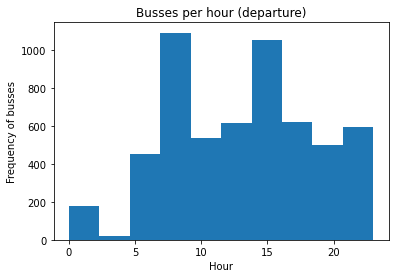

In [28]:
# create figure and axis
figH, axH = plot.subplots()
# plot histogram
axH.hist(df2['Avgang_Time'])
# set title and labels
axH.set_title('Busses per hour (departure)')
axH.set_xlabel('Hour')
axH.set_ylabel('Frequency of busses')

## Feature Engineering 6: Passengers per hour

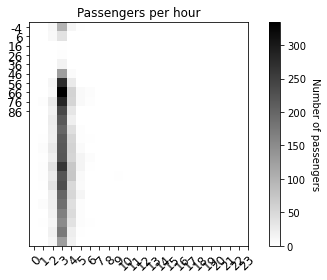

In [29]:
def countPassengers(rowNameX, rowNameY):
    
    minPass = df2[rowNameY].min()
    maxPass = df2[rowNameY].max() - minPass
    if(maxPass<0):
        maxPass = -maxPass
    bins = math.ceil(maxPass/100)*10
    grid = np.zeros((24, bins))
    
    #Calculate minimum and maximum minute values (min/max ticks)
    i=0
    minBin, minRest = divmod(minPass, 10)
    maxBin, maxRest = divmod(maxPass, 10)
    
    #Calculate number of ticks and add corresponding label
    nrTicks = bins
    ticks = [None] * nrTicks
    
    while i<nrTicks:
        ticks[i] = minBin + (i*10)
        i = i+1
        
    hours = list(range(24))
    
    #Populate grid array
    for j, row in df2.iterrows():
        hour = row[rowNameX]
        passengers = row[rowNameY] - minPass
        toBin = math.floor((passengers/maxPass)*(bins-1))
        
        k=0
        while k<24:
            if hour==k:
                grid[k, toBin] = grid[k, toBin] + 1
            k=k+1     
    
    #Define heatmap
    fig, ax = plot.subplots()
    im = ax.imshow(grid, cmap='gist_yarg')
    #ax.set_aspect(7)

    #Setting up ticks
    ax.set_xticks(np.arange(len(hours)))
    plot.xticks(np.arange(0, 24, step=1))
    ax.set_xticklabels(hours)
    
    ax.set_yticklabels(ticks)
    ax.set_yticks(np.arange(len(ticks)))
    
    ax.tick_params(axis='both', labelsize=12)
    plot.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    
    #Colourbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Number of passengers", rotation=-90, va="bottom")
    
    #Set title and show
    ax.set_title("Passengers per hour")
    fig.tight_layout()
    plot.show()

#Call function
countPassengers('Avgang_Time', 'Passasjerer_Flux')